In [5]:
import universalbands as ub
from universalbands.kernels import Matern
from GPy.kern import Matern52
from GPy.models.gp_regression import GPRegression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import kernels

def plot(X, y, X_cal, y_cal, X_test, y_test, mean_estimation_test, bands_estimation_test, gp_preds, limits, title, save_path):
    line_width = 5
    marker_size = 120

    # Make the upper bounds and lower bounds from the mean estimation and the prediction bands.
    upper_bound = mean_estimation_test + bands_estimation_test
    lower_bound = mean_estimation_test - bands_estimation_test

    fig, ax = plt.subplots(1, 1, figsize=(10,10))

    X_test_sq = X_test.squeeze()
    mean_est_sq = mean_estimation_test.squeeze()
    gp_preds_sq = gp_preds.squeeze()
    sorted_indices = np.argsort(X_test_sq)
    X_test_sorted = X_test_sq[sorted_indices].squeeze()
    mean_est_sorted = mean_est_sq[sorted_indices].squeeze()
    gp_preds_sorted = gp_preds_sq[sorted_indices].squeeze()

    upper_bound_sq = upper_bound.squeeze()
    lower_bound_sq = lower_bound.squeeze()
    upper_bound_sorted = upper_bound_sq[sorted_indices].squeeze()
    lower_bound_sorted = lower_bound_sq[sorted_indices].squeeze()

    ax.plot(X_test_sorted, mean_est_sorted, color = "blue", linewidth = line_width)
    ax.plot(X_test_sorted, gp_preds_sorted, color = "red", linewidth = line_width, ls = ":")

    ax.fill_between(X_test_sorted, lower_bound_sorted, upper_bound_sorted, alpha = 0.2, color = "orange")

    ax.scatter(X, y, s = marker_size, c = "blue", alpha = 1, marker = "^")
    ax.scatter(X_cal, y_cal, s = marker_size, c = "orange", alpha = 1, marker = "v")
    ax.scatter(X_test, y_test, s = 35, c = "black", alpha = 0.6, marker = "o")

    ax.plot(X_test_sorted, upper_bound_sorted, color = "orange", linewidth = line_width, ls = "--")
    ax.plot(X_test_sorted, lower_bound_sorted, color = "orange", linewidth = line_width, ls = "--")

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_ylim(limits)
    #ax.set_title(label = title, loc = "center")

    plt.tight_layout()
    fig.savefig(save_path, transparent = True, dpi = 600)

Optimization restart 1/5, f = 127.23625548257097
Optimization restart 2/5, f = 127.23625548311414
Optimization restart 3/5, f = 127.23625548225132
Optimization restart 4/5, f = 127.23625548275385
Optimization restart 5/5, f = 127.23625548224601
Length scale for this model is 0.1.
Start solving the SDP problem !
   Solver status: optimal
   Solver took: 2.9264839620000003 seconds
   Solver value: 18.401941928205314
Start calibration !
Start inference !
HSIC for this model is 0.010609168309230158.
Length scale for this model is 0.2.
Start solving the SDP problem !
   Solver status: optimal
   Solver took: 2.793558206 seconds
   Solver value: 14.226059642451546
Start calibration !
Start inference !
HSIC for this model is 0.012149697896859133.
Length scale for this model is 0.30000000000000004.
Start solving the SDP problem !
   Solver status: optimal
   Solver took: 3.1548067470000003 seconds
   Solver value: 12.942277919539269
Start calibration !
Start inference !
HSIC for this model is 

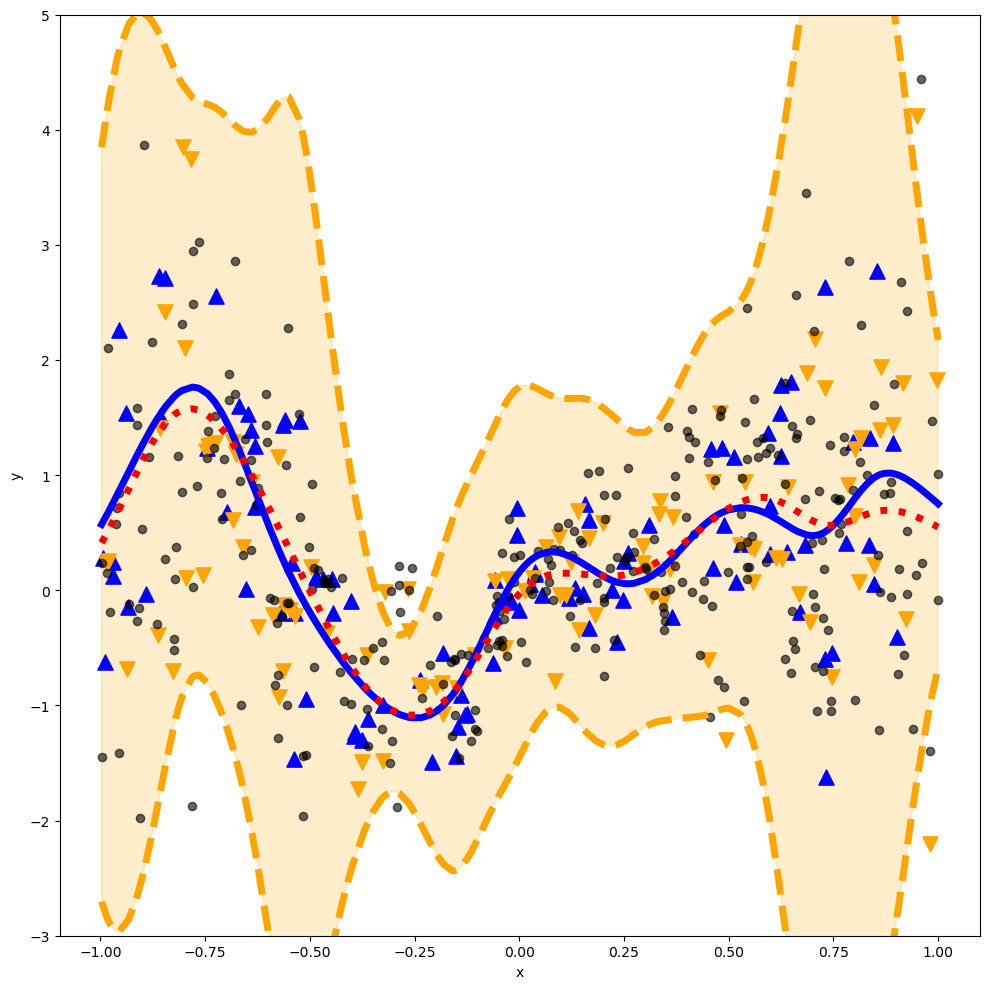

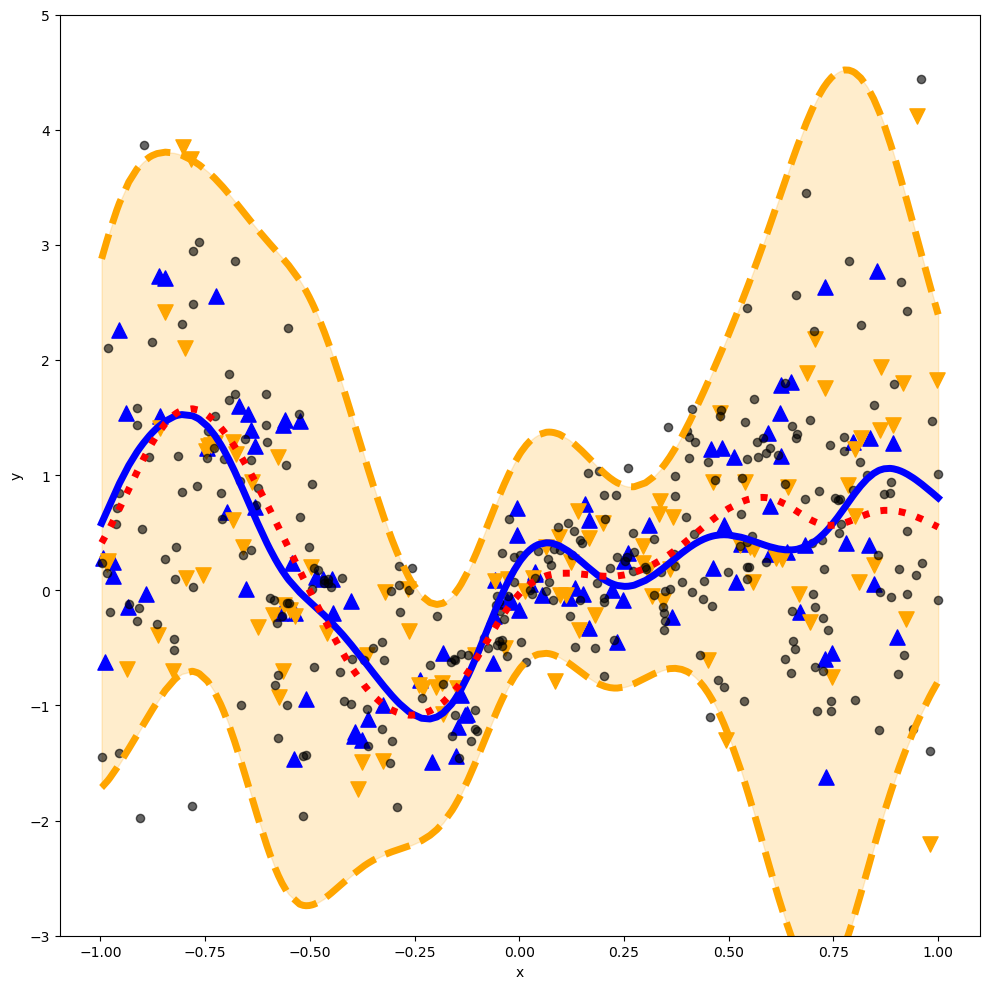

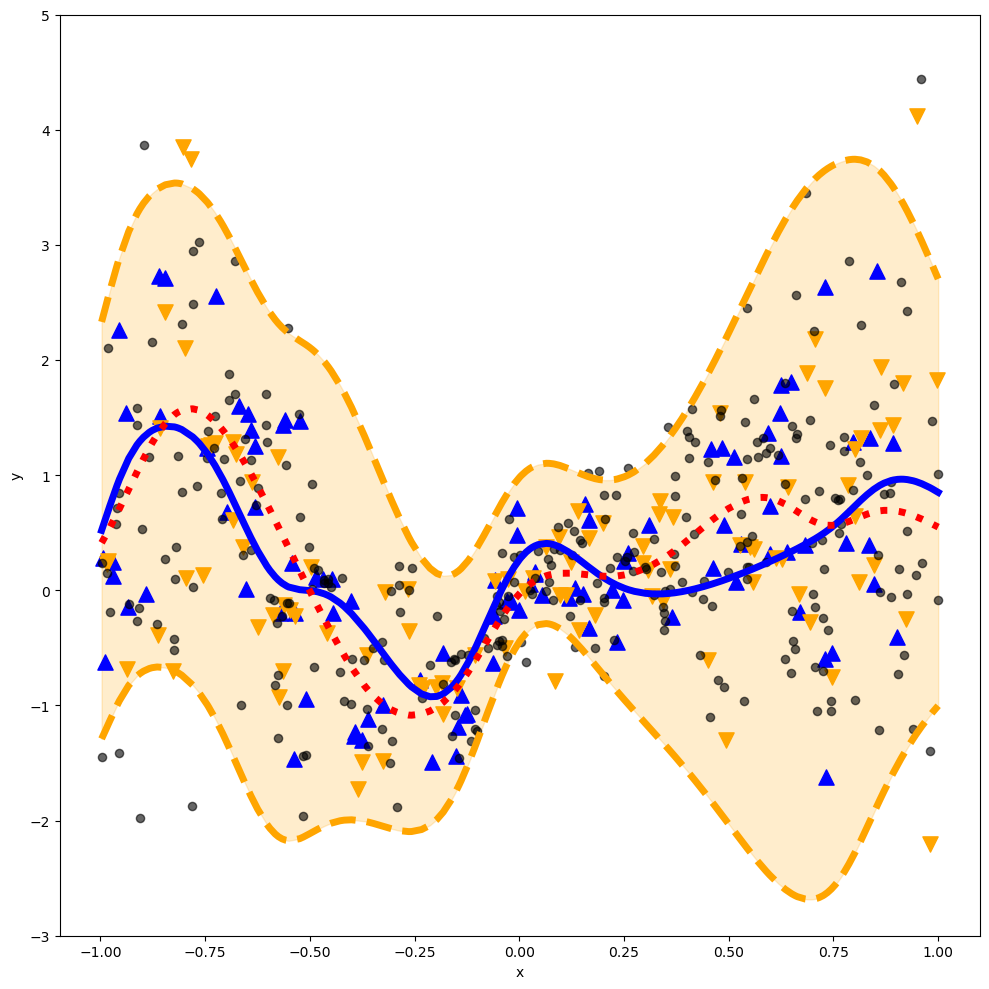

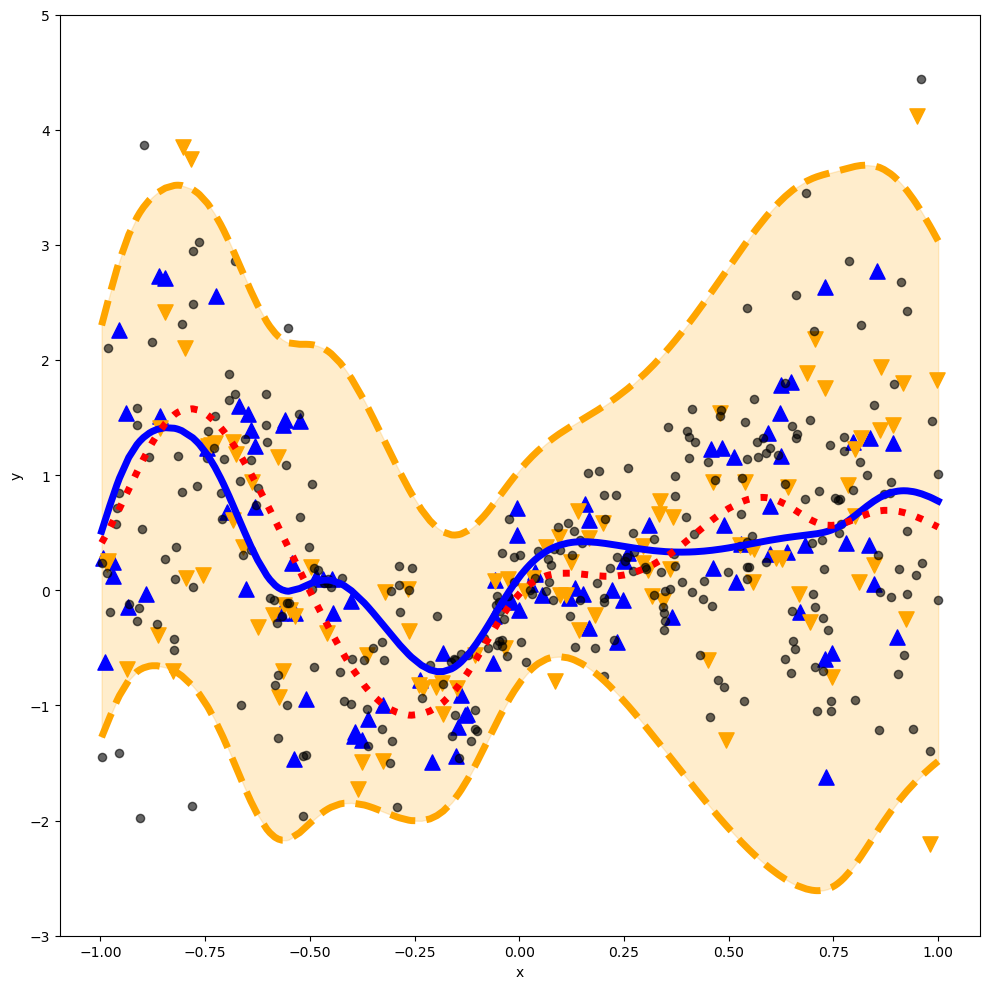

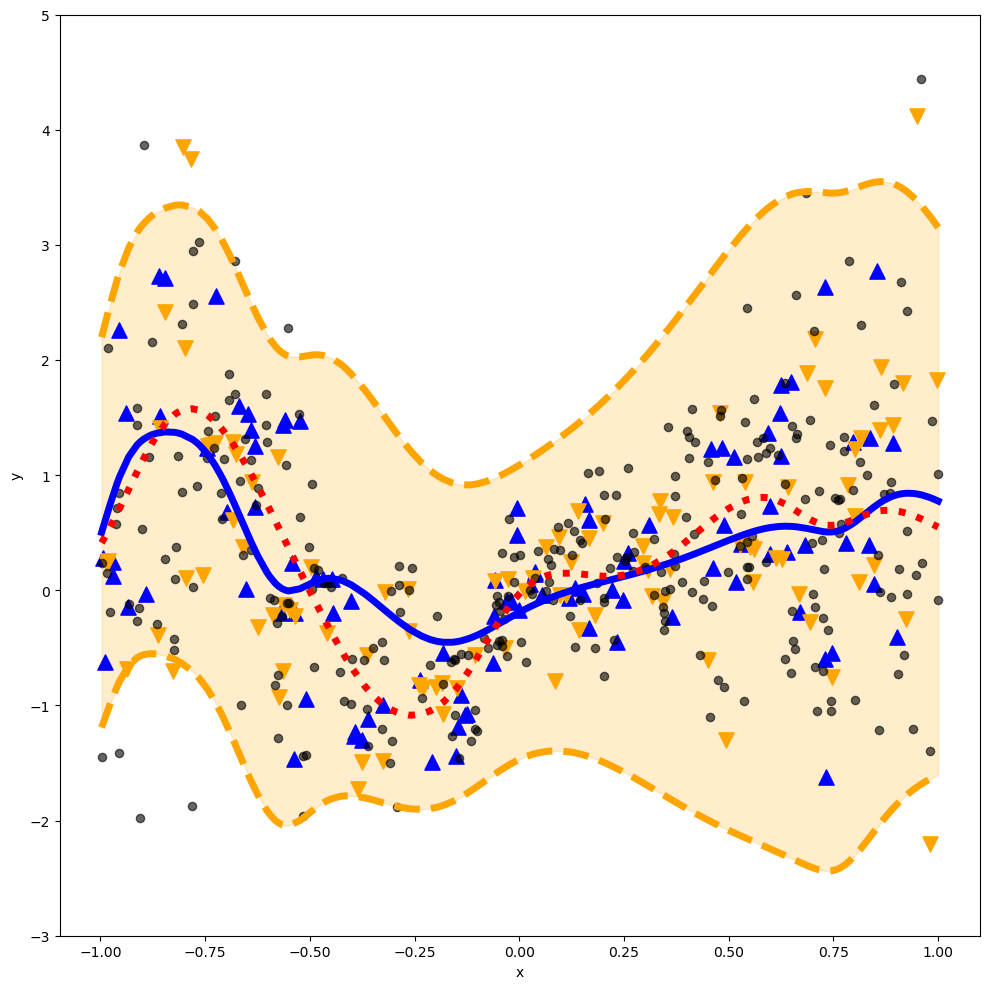

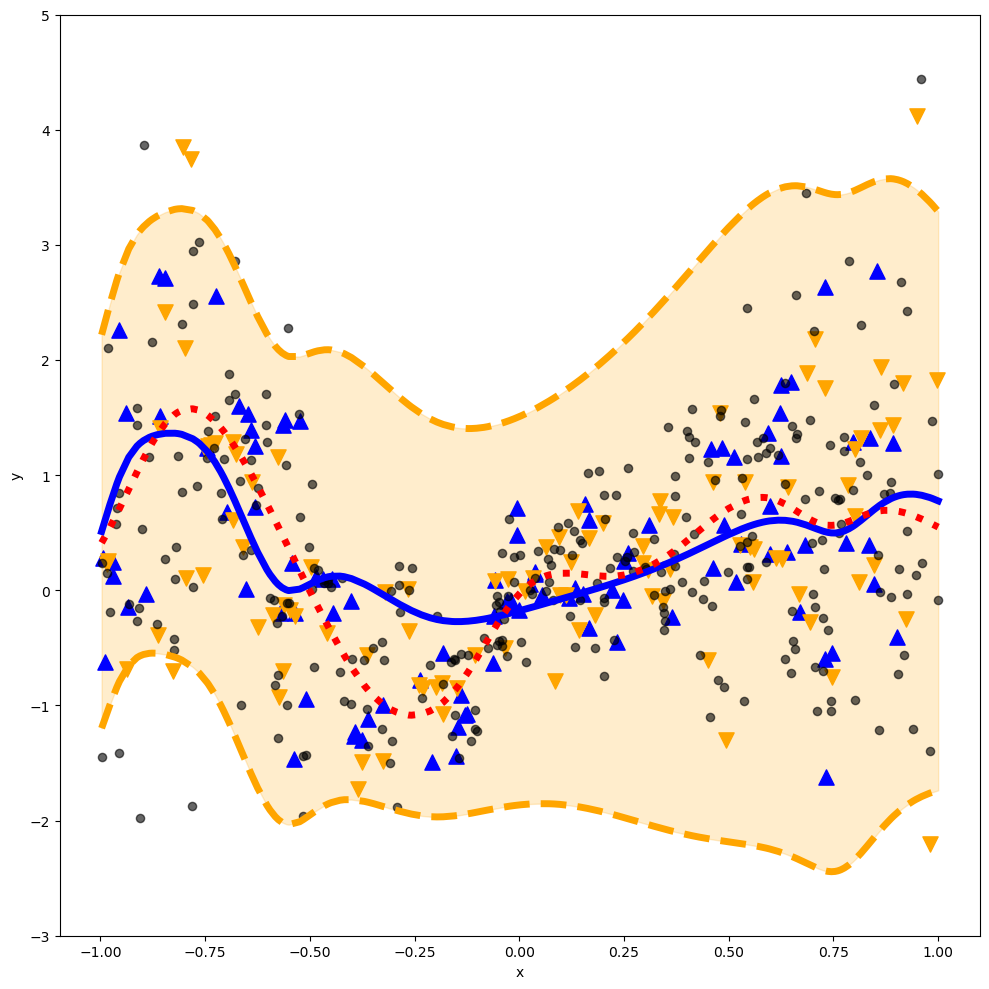

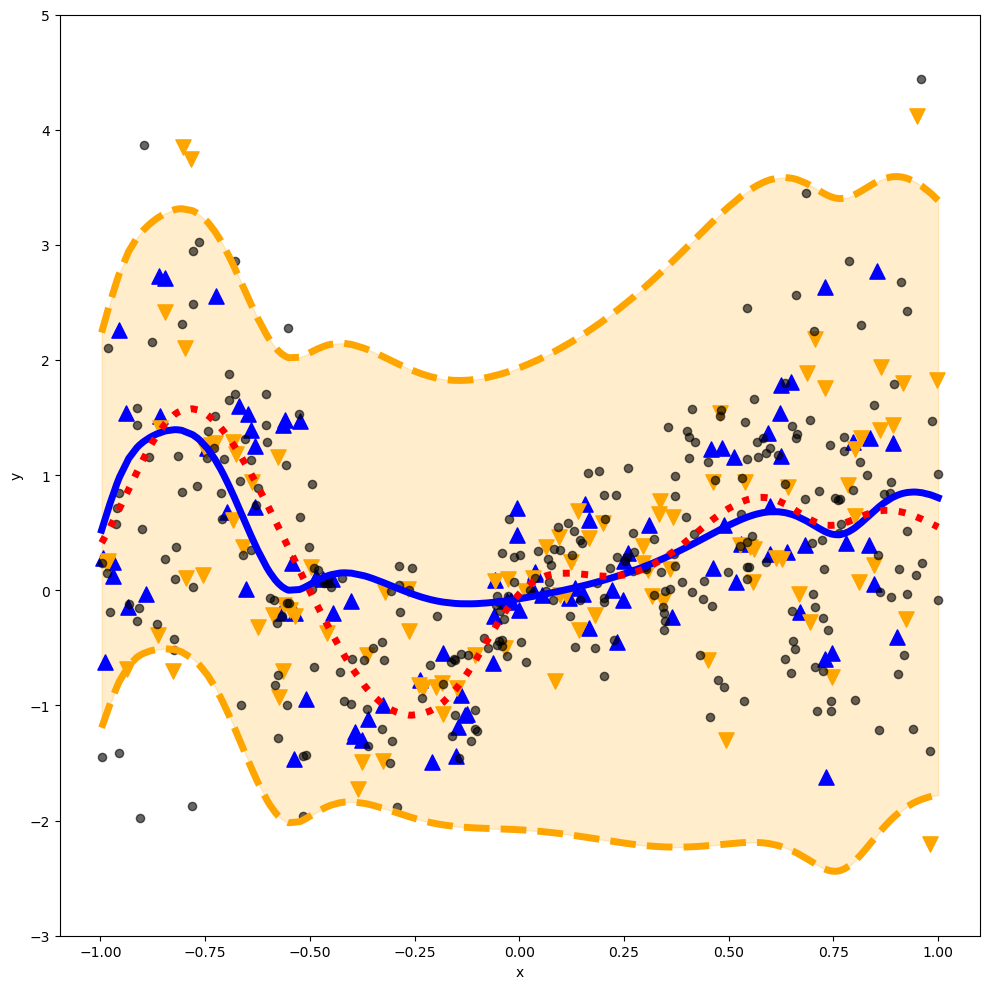

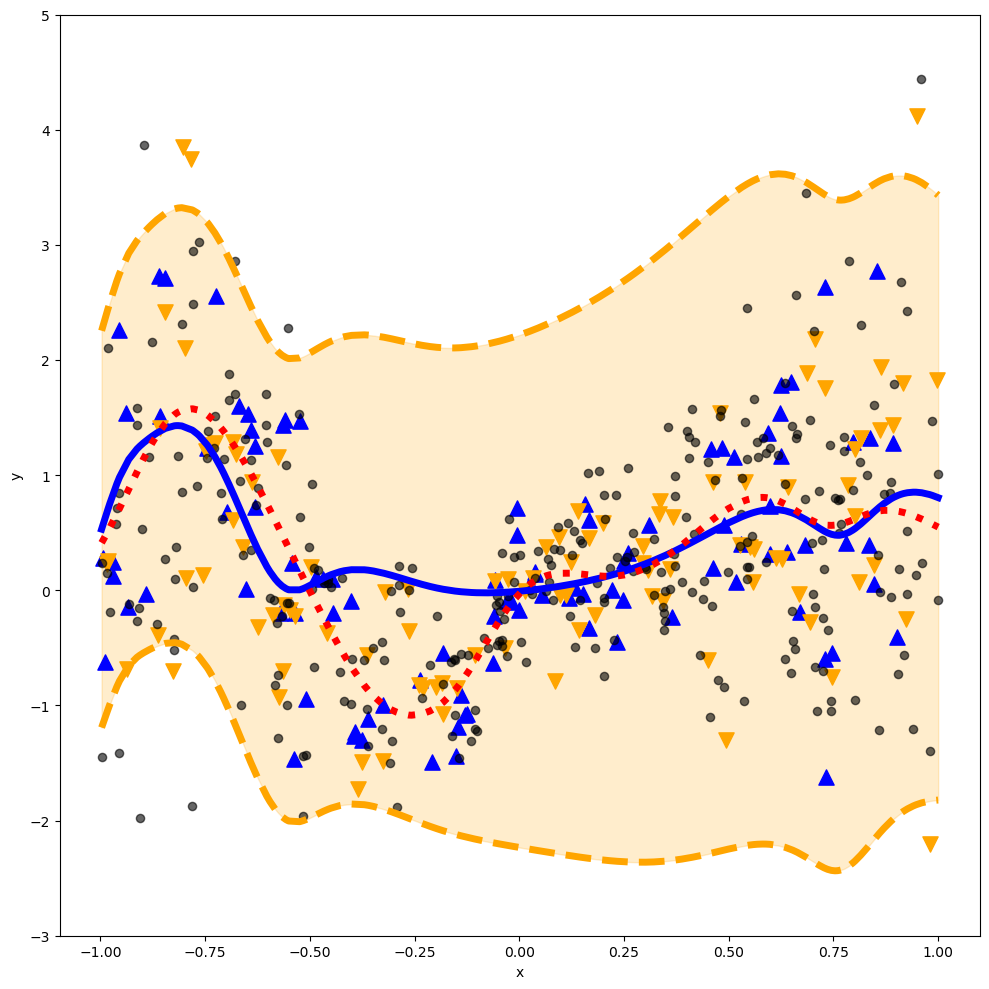

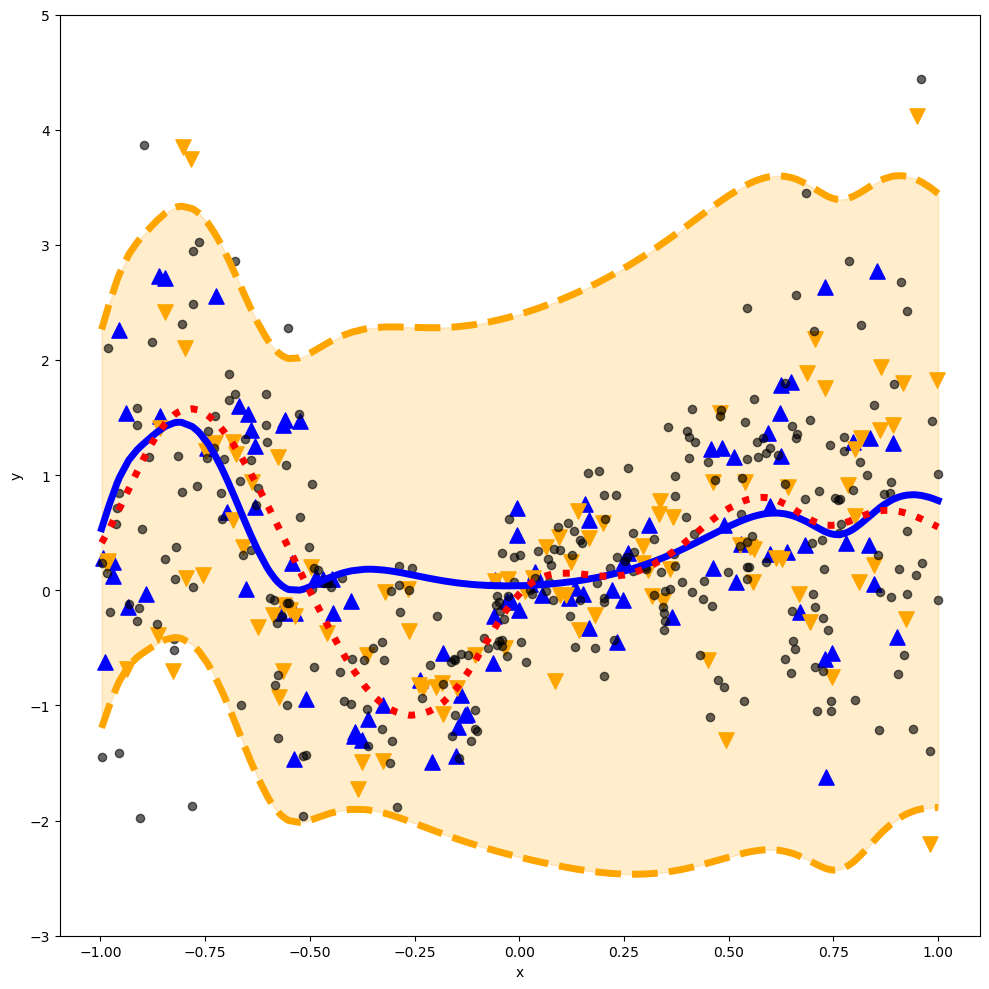

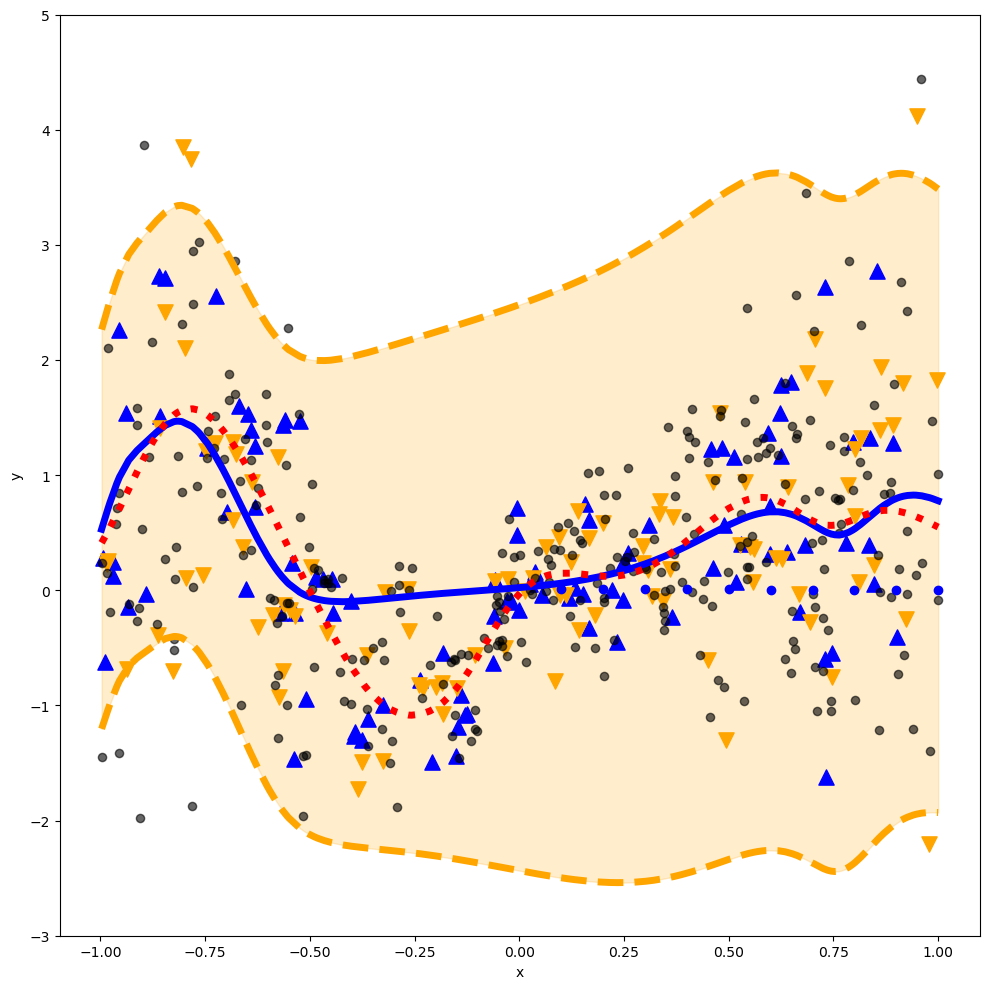

In [11]:
case_number = 5
sample_size = 100
sample_dim = 1

X_train, y_train = ub.data_generation.synthetic_data(case = f"case_{case_number}", sample_size = sample_size + 1, sample_dim = sample_dim, seed = 123)
X_cal, y_cal = ub.data_generation.synthetic_data(case = f"case_{case_number}", sample_size = sample_size + 2, sample_dim = sample_dim, seed = 321)
X_test, y_test = ub.data_generation.synthetic_data(case = f"case_{case_number}", sample_size = 3*sample_size + 3, sample_dim = sample_dim, seed = 987)

kernel = Matern52(input_dim = 1)
gp_model = GPRegression(X_train, y_train, kernel)
gp_model.optimize_restarts(num_restarts = 5, messages = False, verbose = True, max_iters = 1000)
gp_predictions, _ = gp_model.predict(X_test)


posterior_lengthscale = gp_model.kern.lengthscale[0]
posterior_variance = gp_model.kern.variance[0]
posterior_nugget = gp_model.Gaussian_noise.variance[0]
# Reconstruct the norm of the function on the training parameters.
gamma = gp_model.posterior.woodbury_vector
K = gp_model.kern.K(X_train)
post_training_norm = np.matmul(gamma.T, np.matmul(K, gamma))[0][0]

# SDP part
hsic = []
length_scale_list = np.linspace(0.1, 1, 10)

for variance_lengthscale in length_scale_list:
    print(f"Length scale for this model is {variance_lengthscale}.")
    sdp_model = ub.UniversalFunctionAndBandsRegressor(
        mean_kernel = kernels.Matern(length_scale = posterior_lengthscale, length_scale_bounds = (1e-5, 1e5), nu = 2.5),
        variance_kernel = kernels.Matern(length_scale = variance_lengthscale, length_scale_bounds = (1e-5, 1e5), nu = 2.5), 
        #mean_kernel = Matern(length_scale = posterior_lengthscale, sigma = 1, nu = 2.5, nugget = 0),
        #variance_kernel = Matern(length_scale = variance_lengthscale, sigma = 1, nu = 2.5, nugget = 0),
        lambda2 = 1,
        delta = 1e-3,
        s = post_training_norm,
        problem = "Liang",
        checkSDP = False,
        verbose = True
    )
    sdp_model.train(X = X_train, y = y_train)
    sdp_model.calibrate(X = X_cal, y = y_cal, alpha = 0.05, metric_list = ["mutual_information", "energy_hsic"])
    mean_test_prediction, prediction_bands = sdp_model.predict(X = X_test)

    current_hsic = sdp_model.metrics["energy_hsic"]
    hsic.append(current_hsic)
    print(f"HSIC for this model is {current_hsic}.")

    plot(X = X_train, y = y_train, X_cal = X_cal, y_cal = y_cal, X_test = X_test, y_test = y_test, mean_estimation_test = mean_test_prediction, bands_estimation_test = prediction_bands, gp_preds = gp_predictions, limits = (-3, 5), title = "This is my title.", save_path = "figure_01.pdf")

plt.scatter(length_scale_list, np.array(hsic), color = "blue")

In [ ]:
print(length_scale_list)
print(np.array(hsic))

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[0.01060917 0.0121497  0.01483416 0.01470957 0.00857019 0.00409404
 0.00299898 0.00271747 0.00267354 0.00247082]
